**ЦЕЛЬ ИССЛЕДОВАНИЯ**

Провести оценку результатов A/B-теста. 

Необходимо: 
* Оценить корректность проведения теста
* Проанализировать результаты теста

Так же для корректности проведения теста, проверим:

* пересечение тестовой аудитории с конкурирующим тестом,
* совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

Исходные данные:

В распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Техническое задание:

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

#  Выгрузка данных и их изучение

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly import graph_objects as go

import math as mth
from scipy import stats as st
import scipy.stats as stats
import datetime as dt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Посмотр календаря маркетинговых событий на 2020 год

In [3]:
# чтение файла ab_project_marketing_events.csv и сохранение в переменной marketing
if os.path.exists('/datasets/ab_project_marketing_events.csv'):
    marketing = pd.read_csv('/datasets/ab_project_marketing_events.csv', sep = ',', parse_dates=['start_dt', 'finish_dt'], dayfirst=True)
else:
    marketing = pd.read_csv('ab_project_marketing_events.csv', sep = ',', parse_dates=['start_dt', 'finish_dt'], dayfirst=True)

In [4]:
# просмотр первых пяти строк таблицы
marketing.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [5]:
# получение общей информации о данных в таблице 
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [6]:
# проверим наличие явных дубликатов
marketing.duplicated().sum()

0

In [7]:
# проверим значения колонки name
marketing['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [8]:
# проверим значения колонки name
marketing['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

### Вывод:

* тип данных в столбцах start_dt и finish_dt заменили на datetime
* пропусков нет
* дубликатов нет

## Посмотр пользователей, зарегистрированных с 7 по 21 декабря 2020 года

In [9]:
# чтение файла final_ab_new_users.csv и сохранение в переменной new_users
if os.path.exists('/datasets/final_ab_new_users.csv'):
    new_users = pd.read_csv('/datasets/final_ab_new_users.csv', sep = ',', parse_dates=['first_date'], dayfirst=True)
else:
    new_users = pd.read_csv('final_ab_new_users.csv', sep = ',', parse_dates=['first_date'], dayfirst=True)

In [10]:
# просмотр первых пяти строк таблицы
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [11]:
# получение общей информации о данных в таблице 
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [12]:
# проверим наличие явных дубликатов
new_users.duplicated().sum()

0

In [13]:
# проверим значения колонки name
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [14]:
# проверим значения колонки device
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

### Вывод:

* тип данных в столбце first_date заменили на datetime
* пропусков нет
* дубликатов нет

## Посмотр действий новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

In [15]:
# чтение файла final_ab_events.csv и сохранение в переменной final_ab_events
if os.path.exists('/datasets/final_ab_events.csv'):
    events = pd.read_csv('/datasets/final_ab_events.csv', sep = ',', parse_dates=['event_dt'], dayfirst=True)
else:
    events = pd.read_csv('final_ab_events.csv', sep = ',', parse_dates=['event_dt'], dayfirst=True)

In [16]:
# просмотр первых пяти строк таблицы
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [17]:
# получение общей информации о данных в таблице 
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [18]:
# проверим наличие явных дубликатов
events.duplicated().sum()

0

In [19]:
# определеним количество пропусков в процентах
(events.isna().mean().round(4))*100

user_id        0.00
event_dt       0.00
event_name     0.00
details       85.75
dtype: float64

In [20]:
# проверим значения колонки event_name
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [21]:
# посмотрим на события в event_name подробнее
event = (events.groupby('event_name').agg({'user_id': 'count'})
                                       .sort_values(by=['user_id'],ascending=False)
                                       .reset_index()
                                       .rename(columns={'user_id':'count_user'}))
event
event['percent'] = (event['count_user'] / len(events))*100
event.style.format({'percent': '{:.2f}%'})

,event_name,count_user,percent
0,login,189552,43.05%
1,product_page,125563,28.52%
2,purchase,62740,14.25%
3,product_cart,62462,14.19%


### Вывод:
* тип данных в столбце event_dt заменили на datetime
* дубликатов нет
* пропуски есть - в столбце details, количество пропущенных значений 85,75%, но они объяснимы, так как в этом поле хранится стоимость покупки в долларах, а purchase у нас всего 14,25%, то как раз 85,75 и приходится на все остальные события не purchase.
* в столбце event_name 43,05% составляет значение login. Это может говорить о том, что пользователь только зарегестрировался и больше ничего на сайте не делал.


## Посмотр таблицы участников тестов

In [22]:
# чтение файла final_ab_participants.csv и сохранение в переменной final_ab
if os.path.exists('/datasets/final_ab_participants.csv'):
    participants = pd.read_csv('/datasets/final_ab_participants.csv', sep = ',')
else:
    participants = pd.read_csv('final_ab_participants.csv', sep = ',')

In [23]:
# просмотр первых пяти строк таблицы
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [24]:
# получение общей информации о данных в таблице 
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [25]:
# проверим наличие явных дубликатов
participants.duplicated().sum()

0

### Вывод:
* дубликатов нет
* пропусков нет


# Исследовательский анализ данных

## Оценка корректности проведения теста

### Проверка на соответствие данных требованиям технического задания. 

**1. Название теста: recommender_system_test**

In [26]:
# проверим значения колонки group
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В данных присутствую два теста одновременно

**2. Группы: А — контрольная, B — новая платёжная воронка**

In [27]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

Группы соответствуют заданию

**3. Дата запуска: 2020-12-07**

In [28]:
#оставляем в датасете только пользователей из Европы согласно ТЗ
new_users = new_users[new_users['region'] == 'EU']

In [29]:
# соеденим таблицы new_users и participants и отбросим пустые значения
ab_new_users = new_users.merge(participants, on='user_id', how='right').dropna()
ab_new_users.head()

,user_id,first_date,region,device,group,ab_test
0,D1ABA3E2887B6A73,2020-12-07,EU,PC,A,recommender_system_test
1,A7A3664BD6242119,2020-12-20,EU,iPhone,A,recommender_system_test
2,DABC14FDDFADD29E,2020-12-08,EU,Mac,A,recommender_system_test
3,DABC14FDDFADD29E,2020-12-08,EU,Mac,A,interface_eu_test
4,04988C5DF189632E,2020-12-14,EU,iPhone,A,recommender_system_test


In [30]:
# посмотрим первую дату у нужного нам теста у группы А
ab_new_users.query('group=="A" and ab_test=="recommender_system_test"')['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [31]:
# посмотрим первую дату у нужного нам теста у группы В
ab_new_users.query('group=="B" and ab_test=="recommender_system_test"')['first_date'].min()

Timestamp('2020-12-07 00:00:00')

Дата запуска действительно с 07.12.2020 у обоих групп.

**4. Дата остановки набора новых пользователей: 2020-12-21**

In [32]:
# посмотрим последнюю дату у нужного нам теста у группы А
ab_new_users.query('group=="A" and ab_test=="recommender_system_test"')['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [33]:
# посмотрим последнюю дату у нужного нам теста у группы А
ab_new_users.query('group=="B" and ab_test=="recommender_system_test"')['first_date'].max()

Timestamp('2020-12-21 00:00:00')

Дата остановки набора новых пользователей действительно 21.12.2020 у обоих групп.

**5. Дата остановки теста: 2021-01-04**

In [34]:
# соеденим таблицы events и  participants и отбросим пустые значения
ab_event = events.merge(participants, on='user_id', how='right')
ab_event.head()

,user_id,event_dt,event_name,details,group,ab_test
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A,recommender_system_test
1,D1ABA3E2887B6A73,2020-12-25 00:04:56,purchase,4.99,A,recommender_system_test
2,D1ABA3E2887B6A73,2020-12-07 14:43:29,product_cart,NaN,A,recommender_system_test
3,D1ABA3E2887B6A73,2020-12-25 00:04:57,product_cart,NaN,A,recommender_system_test
4,D1ABA3E2887B6A73,2020-12-07 14:43:27,product_page,NaN,A,recommender_system_test


In [35]:
# посмотрим последнюю дату события пользователей у нужного нам теста у группы А
ab_event.query('group=="A" and ab_test=="recommender_system_test"')['event_dt'].max()

Timestamp('2020-12-29 23:38:29')

In [36]:
# посмотрим последнюю дату события пользователей у нужного нам теста у группы В
ab_event.query('group=="B" and ab_test=="recommender_system_test"')['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

**6. Аудитория: 15% новых пользователей из региона EU**

In [37]:
(len(ab_new_users.query('ab_test=="recommender_system_test"'))/len(new_users[new_users['region'] == 'EU'])*100)

13.725956343202938

Есть небольшое расхождение с ТЗ

**7. Ожидаемое количество участников теста: 6000.**

In [38]:
ab_new_users['region'].value_counts()

EU    17918
Name: region, dtype: int64

In [39]:
ab_new_users.query('ab_test=="recommender_system_test"')['user_id'].nunique()

6351

Количество участников теста больше ожидаемого. Больше не меньше, критичного нет в таком количестве.

### Проверка времени проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.

In [40]:
# сохраним в переменной все даты начала регистрации
time_test_1 = new_users['first_date'].dt.date

In [41]:
# сохраним в переменной все даты событий
time_test_2 = events['event_dt'].dt.date

In [42]:
# проверим если даты регистрации или событий в маркетинговых событиях
marketing.query('start_dt in @time_test_1 or start_dt in @time_test_2')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Два маркетинговых исследования попали в тест, но так как нас интересуют только жители Европы, во внимание можно брать только акцию "Christmas&New Year Promo".

### Проверка аудиторию теста.  

Убедимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.

In [43]:
# найдем всех пользователей интересующего нас теста recommender_system_test
user_recommender = ab_new_users.query('ab_test=="recommender_system_test"')['user_id']

In [44]:
# найдем всех пользователей паралельному тесту interface_eu_test
user_interface = ab_new_users.query('ab_test=="interface_eu_test"')['user_id']

In [45]:
# посмотрим все user_id, которые попали оба теста
user_duplicates = ab_new_users.query('user_id in @user_recommender and user_id in @user_interface')
user_duplicates.head(6)

,user_id,first_date,region,device,group,ab_test
2,DABC14FDDFADD29E,2020-12-08,EU,Mac,A,recommender_system_test
3,DABC14FDDFADD29E,2020-12-08,EU,Mac,A,interface_eu_test
4,04988C5DF189632E,2020-12-14,EU,iPhone,A,recommender_system_test
5,04988C5DF189632E,2020-12-14,EU,iPhone,A,interface_eu_test
12,B3A2485649E4A012,2020-12-09,EU,iPhone,A,recommender_system_test
13,B3A2485649E4A012,2020-12-09,EU,iPhone,A,interface_eu_test


In [46]:
# Количсетво пользователей, которые в обоих тестах
len(user_duplicates)/2

1602.0

Проверка равномерности распределения по тестовым группам и правильность их формирования.

In [47]:
group_a_b = (participants.groupby(['ab_test', 'group']).agg({'user_id': 'nunique'})
                                       .sort_values(by=['user_id'],ascending=False)
                                       .reset_index()
                                       .rename(columns={'user_id':'count_user'}))
group_a_b
group_a_b['percent'] = (group_a_b['count_user'] / len(participants))*100
group_a_b.style.format({'percent': '{:.2f}%'})

,ab_test,group,count_user,percent
0,interface_eu_test,A,5831,31.92%
1,interface_eu_test,B,5736,31.40%
2,recommender_system_test,A,3824,20.93%
3,recommender_system_test,B,2877,15.75%


Посмотрим не попал ли один и тот же пользователь в одну и туже группу

In [48]:
user_A = ab_new_users.query('ab_test=="recommender_system_test" and group=="A"')['user_id']

In [49]:
user_B = ab_new_users.query('ab_test=="recommender_system_test" and group=="B"')['user_id']

In [50]:
user_duplicates = ab_new_users.query('user_id in @user_A and user_id in @user_B')
user_duplicates

,user_id,first_date,region,device,group,ab_test


Пользователи в группах не пересекаются.

## Распеределение количества событий на пользователя в выборках.

Text(0.5, 0, 'Кол-во событий')

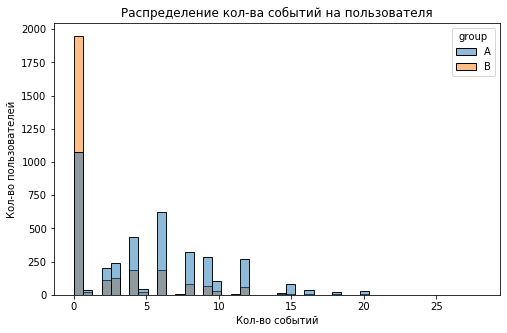

In [51]:
# построим график распределения количества событий на пользователя для двух выборок нашего теста
plt.figure(figsize=(8, 5))
sns.histplot(data = ab_event.query('ab_test=="recommender_system_test"').groupby(['group', 'user_id'])['event_name'].count().reset_index(), x = 'event_name', hue="group")
plt.title("Распределение кол-ва событий на пользователя")
plt.ylabel("Кол-во пользователей")
plt.xlabel("Кол-во событий")

Нулевая гипотеза: количество событий на пользователя между пользователями группы А и В равны.

Альтернативная гипотеза: количество событий на пользователя между пользователями группы А и В не равны.

In [52]:
# найдем распределение событий на пользователя
event_a = (ab_event.query('group=="A" and ab_test=="recommender_system_test"')
                       .groupby(['user_id'])['event_name'].count()
                       .reset_index().rename(columns={'event_name':'cnt_event'}))
event_b = (ab_event.query('group=="B" and ab_test=="recommender_system_test"')
                       .groupby(['user_id'])['event_name'].count()
                       .reset_index().rename(columns={'event_name':'cnt_event'}))
# выборка числа событий группы А
cnt_event_a = event_a['cnt_event']
# выборка числа событий группы В
cnt_event_b = event_b['cnt_event']

alpha = 0.05 

results = st.ttest_ind(cnt_event_a, cnt_event_b)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.677337645850247e-203
Отвергаем нулевую гипотезу


## Распределение числа событий в выборках по дням

Text(0.5, 0, 'Кол-во событий')

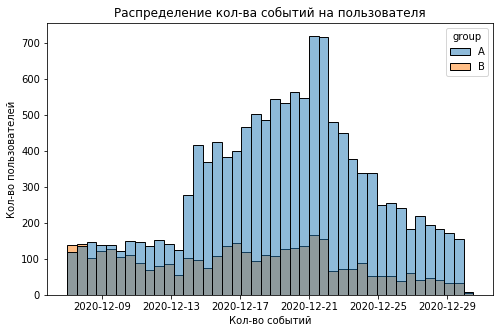

In [53]:
# построим график распределения количества событий на пользователя для двух выборок нашего теста
plt.figure(figsize=(8, 5))
sns.histplot(data = ab_event.query('ab_test=="recommender_system_test"').groupby(['group', 'user_id', 'event_dt'])['event_name'].count().reset_index(), x = 'event_dt', hue="group")
plt.title("Распределение кол-ва событий на пользователя")
plt.ylabel("Кол-во пользователей")
plt.xlabel("Кол-во событий")

* В группе А с 14 декабря наблюдается резкое увеличение событий. Возможно, это регистрации новых пользователей или покупки подарков на рождество. Максимальное количество событий 22 декабря. 
* В группе В всплеска активности не наблюдается. Вероятно, что новые регистрации учитывались в группе А.
* Или 14 числа произошел сбой, который и влияет на результаты анализа.

## Изменение конверсии в воронке в выборках на разных этапах.

In [54]:
# отфильтруем участников, которые участвуют одновременно в двух тестах и оставим только нужный нам тест
ab_event = ab_event.query('user_id not in @user_duplicates and ab_test=="recommender_system_test"')


In [55]:
# переименуем некоторые названия действий, чтобы они выстроились в нужной последовательности для воронки
ab_event['event_name'] = ab_event['event_name'].replace('login', 'alogin')
ab_event['event_name'] = ab_event['event_name'].replace('product_page', 'browse_page')

In [56]:
# посмотрим на события в event_name с группировкой по группам и событиям
event = (ab_event.groupby(['event_name', 'group']).agg({'user_id': 'nunique'})
                                       .sort_values(by=['group', 'event_name'])
                                       .reset_index()
                                       .rename(columns={'user_id':'cnt_event'}))

event 

,event_name,group,cnt_event
0,alogin,A,2747
1,browse_page,A,1780
2,product_cart,A,824
3,purchase,A,872
4,alogin,B,928
5,browse_page,B,523
6,product_cart,B,255
7,purchase,B,256


In [57]:
# при помощи функции добавим столбец с конверсией каждого этапа
def get_conversion(row):
    group = row['group']
    cnt_event = row['cnt_event']
    a_100  = 2747
    b_100  = 928
    if group == "A":
        return round((cnt_event /a_100)*100, 1)
    if group == "B":
        return round((cnt_event /b_100)*100, 1)
event['cr%'] = event.apply(get_conversion, axis = 1)
event

,event_name,group,cnt_event,cr%
0,alogin,A,2747,100.0
1,browse_page,A,1780,64.8
2,product_cart,A,824,30.0
3,purchase,A,872,31.7
4,alogin,B,928,100.0
5,browse_page,B,523,56.4
6,product_cart,B,255,27.5
7,purchase,B,256,27.6


## Вывод:

Тест проведен не корректно. 

Причины почему тест проведен не корректно:
* в данных выявленно одновременно два теста
* тест завершился раньше срока. У группы А - 29 декабря, у группы В - 30 декабря. По ТЗ он должен завершится 04.01.2021. Не полные данные могут повлиять на результаты теста.
* Из региона EU ~13.73% новых пользователей. Не соответствие тех. заданию.
* Во время теста происходит два маркетинговых события "Рождественская и новогодняя акция" и "Новогодняя подарочная лотерея СНГ"
* 1602 пользователя участвуют одновременно в двух тестах.
* Пользователи распределены неравномерно по тестовым группам, в интересующем нас тесте разница между группами около 5%, это может исказить результаты теста.

Были выявлены следующие особенности:

* Количество событий на пользователя распределены в выборках не одинаково
* Число событий в выборках распределено по дням не равномерно
* Посмотрев на конверсию в воронке в выборках на разных этапах видно, что ожидаемго эффекта не произошло: пользователи не показали улучшение каждой метрики не менее, чем на 10%.
* Больше всего пользователей теряются между регистрацией и просмотром карточек.
* Количество пользователей, совершивших покупку, больше, чем количествово пользователей, попавших в корзину - вероятно, это связано с тем, что часть пользователей совершили покупку, минуя корзину.

# Оценка результатов A/B-тестирования

Прежде чем мы будем оценивать результаты теста, еще раз стоит обратить внимание, что были выявленны много нарушений при проведении теста, это может исказить результат, поэтому при оценки его не стоит полностью полагаться и доверять его результатам.

## Анализ А/В-тестирования

### Построение графиков кумулятивной выручки по группам и кумулятивного среднего чека по группам

In [58]:
# создадим таблицу с заказами
orders = ab_event.query('event_name=="purchase"')[['user_id', 'event_dt', 'event_name', 'details', 'group']]
orders.head()

,user_id,event_dt,event_name,details,group
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A
1,D1ABA3E2887B6A73,2020-12-25 00:04:56,purchase,4.99,A
20,04988C5DF189632E,2020-12-14 18:51:34,purchase,4.99,A
21,04988C5DF189632E,2020-12-15 02:39:20,purchase,4.99,A
22,04988C5DF189632E,2020-12-18 04:33:43,purchase,9.99,A


In [59]:
# добавим столбец с индификатором заказа, для того, чтоб потом посчитать количество заказов в выбранную дату
orders['order_id'] = np.arange(orders.shape[0])
orders.head()

,user_id,event_dt,event_name,details,group,order_id
0,D1ABA3E2887B6A73,2020-12-07 14:43:27,purchase,99.99,A,0
1,D1ABA3E2887B6A73,2020-12-25 00:04:56,purchase,4.99,A,1
20,04988C5DF189632E,2020-12-14 18:51:34,purchase,4.99,A,2
21,04988C5DF189632E,2020-12-15 02:39:20,purchase,4.99,A,3
22,04988C5DF189632E,2020-12-18 04:33:43,purchase,9.99,A,4


In [60]:
# переведем тип данных 
orders['event_dt'] = orders['event_dt'].dt.date
ab_event['event_dt'] = ab_event['event_dt'].dt.date

In [61]:
# создадим датафрейм с количеством пользователей в указанную дату в указанной группе A/B-теста
visitors = (ab_event.groupby(['event_dt', 'group']).agg({'user_id': 'nunique'})
                                       .sort_values(by=['group', 'event_dt'])
                                       .reset_index()
                                       .rename(columns={'user_id':'visitors'}))

visitors.head()

,event_dt,group,visitors
0,2020-12-07,A,154
1,2020-12-08,A,160
2,2020-12-09,A,178
3,2020-12-10,A,165
4,2020-12-11,A,185


In [62]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['event_dt','group']].drop_duplicates() 
datesGroups.head()

,event_dt,group
0,2020-12-07,A
1,2020-12-25,A
20,2020-12-14,A
21,2020-12-15,A
22,2020-12-18,A


In [63]:
# Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, 
# а группа теста равна группе из datesGroups
ordersAggregated = (datesGroups.apply(lambda x: orders[np.logical_and(orders['event_dt'] <= x['event_dt'], orders['group'] == x['group'])]
.agg({'event_dt' : 'max', 'group' : 'max', 'order_id' : 'nunique', 'user_id' : 'nunique', 'details' : 'sum'}), axis=1).sort_values(by=['event_dt','group'])) 
ordersAggregated.head()

,event_dt,group,order_id,user_id,details
0,2020-12-07,A,46,46,1214.54
129,2020-12-07,B,59,59,704.41
6867,2020-12-08,A,83,72,1994.17
267,2020-12-08,B,94,71,1199.06
78,2020-12-09,A,134,95,3363.66


In [64]:
# получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:
visitorsAggregated = (datesGroups.apply(lambda x: visitors[np.logical_and(visitors['event_dt'] <= x['event_dt'], visitors['group'] == x['group'])]
                                       .agg({'event_dt' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['event_dt','group'])) 
visitorsAggregated.head()

,event_dt,group,visitors
0,2020-12-07,A,154
129,2020-12-07,B,173
6867,2020-12-08,A,314
267,2020-12-08,B,293
78,2020-12-09,A,492


In [65]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['event_dt', 'group'], right_on=['event_dt', 'group'])
cumulativeData.columns = ['event_dt', 'group', 'orders', 'buyers', 'details', 'visitors']
cumulativeData.head()

,event_dt,group,orders,buyers,details,visitors
0,2020-12-07,A,46,46,1214.54,154
1,2020-12-07,B,59,59,704.41,173
2,2020-12-08,A,83,72,1994.17,314
3,2020-12-08,B,94,71,1199.06,293
4,2020-12-09,A,134,95,3363.66,492


In [66]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['event_dt','details', 'orders']]

In [67]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['event_dt','details', 'orders']]

(array([737768., 737772., 737776., 737780., 737784., 737788.]),
 <a list of 6 Text xticklabel objects>)

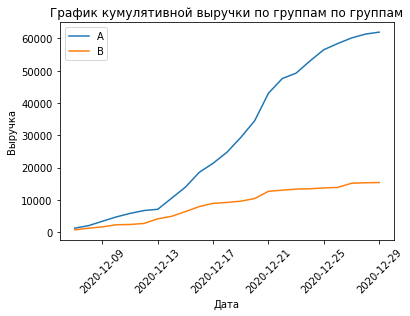

In [68]:
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['event_dt'], cumulativeRevenueA['details'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['event_dt'], cumulativeRevenueB['details'], label='B')
plt.title('График кумулятивной выручки по группам по группам') 
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend() 
plt.xticks(rotation = 45)

Выручка у группы В равномерно увеличивается в течение всего теста. Хороший знак. У группы А график выручки растет более интенсивно, но это лишь подтверждает наши исследования выше, что в группе А больше количество пользователей, чем в группе В. 

(array([737768., 737772., 737776., 737780., 737784., 737788.]),
 <a list of 6 Text xticklabel objects>)

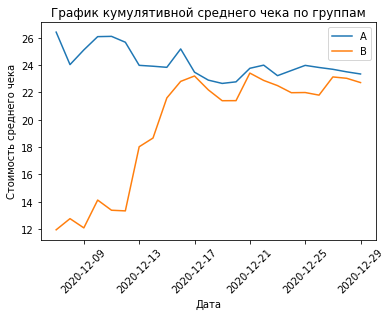

In [69]:
# Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['event_dt'], cumulativeRevenueA['details']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['event_dt'], cumulativeRevenueB['details']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('График кумулятивной среднего чека по группам') 
plt.xlabel('Дата')
plt.ylabel('Стоимость среднего чека')
plt.xticks(rotation = 45)

* Средний чек к концу теста начал немного стабилизироваться.
* Возможно, в группу B 11-12 декабря попали крупные заказы (резкий всплеск на графике).


### Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

In [70]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='event_dt', right_on='event_dt', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head()

,event_dt,detailsA,ordersA,detailsB,ordersB
0,2020-12-07,1214.54,46,704.41,59
1,2020-12-08,1994.17,83,1199.06,94
2,2020-12-09,3363.66,134,1618.66,134
3,2020-12-10,4693.20,180,2258.40,160
4,2020-12-11,5792.78,222,2353.24,176


Text(0, 0.5, 'Относительный прирост')

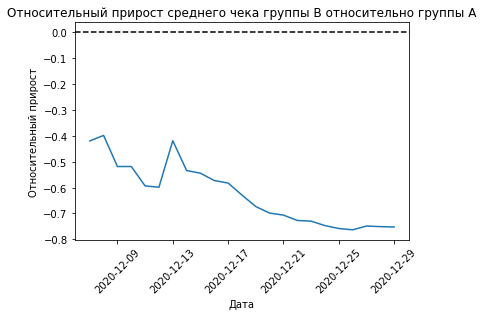

In [71]:
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['event_dt'], (mergedCumulativeRevenue['detailsB']/mergedCumulativeRevenue['ordersA'])/(mergedCumulativeRevenue['detailsA']/mergedCumulativeRevenue['ordersA'])-1)
plt.title('Относительный прирост среднего чека группы B относительно группы A')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xticks(rotation = 45) 
plt.xlabel('Дата')
plt.ylabel('Относительный прирост')

В нескольких точках график различия между сегментами резко «скачет». Где-то скорее всего спрятались крупные заказы и выбросы. Группа В значительно хуже группы А, но возможно, если бы распределение пользователей между группами было равномерным, то результат был бы другой.

### Построение графика кумулятивной конверсии по группам. 

In [72]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [73]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

Text(0, 0.5, 'Конверсия')

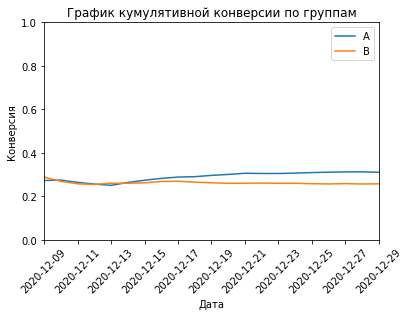

In [74]:
# строим графики
plt.plot(cumulativeDataA['event_dt'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['event_dt'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation = 45)
# задаем масштаб осей
plt.axis([dt.datetime(2020, 12, 9), dt.datetime(2020, 12, 29), 0, 1])
plt.title('График кумулятивной конверсии по группам') 
plt.xlabel('Дата')
plt.ylabel('Конверсия')

Не симметричный график. Конверсия группы А вырвалась выше, обе конверсии стабилизировались к концу теста и зафиксировались.

### Построение график относительного изменения кумулятивной конверсии группы B к группе A.

Text(0, 0.5, 'Прирост конверсии')

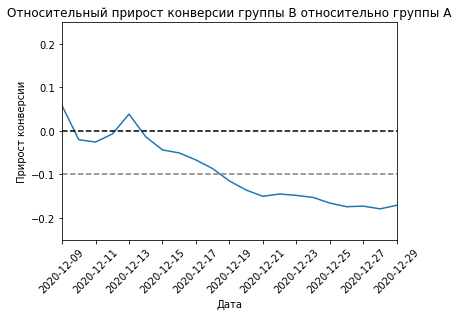

In [75]:
mergedCumulativeConversions = cumulativeDataA[['event_dt','conversion']].merge(cumulativeDataB[['event_dt','conversion']], left_on='event_dt', right_on='event_dt', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['event_dt'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xticks(rotation = 45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2020, 12, 9), dt.datetime(2020, 12, 29), -0.25, 0.25])
plt.xlabel('Дата')
plt.ylabel('Прирост конверсии')

В начале теста были колебания, с середины теста и до конца относительный прирост гр. В падает и вряд ли уже начнет расти.

### Построение точечных графиков количества заказов по пользователям и стоимостей заказов

In [76]:
# Подсчитаем количество заказов по пользователям 
ordersByUsers = (orders.groupby('user_id', as_index=False)
                       .agg({'order_id': 'nunique'}))
ordersByUsers.columns = ['user_id', 'orders']
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
830,B8EF6F0325A9979F,7
610,89545C7F903DBA34,7
549,7949B3058A8B10CB,7
77,1198061F6AF34B7B,7
715,A1C3D3C6C3CADDC5,6
925,CD2093CEF3BC0554,6
921,CBB70C31A7269CA7,6
728,A3AD6954A1CBD2AF,6
133,1BFEE479308EFF44,6
1052,EE869B31C10C205E,6


Text(0, 0.5, 'Кол-во заказов')

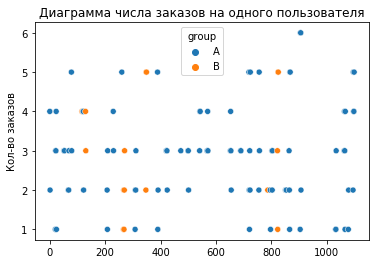

In [77]:
# Построим точечную диаграмму числа заказов на одного пользователя по группам:
x_values = pd.Series(range(0,len(ordersByUsers)))
sns.scatterplot(x=x_values, y=ordersByUsers['orders'], hue=orders['group']) 
plt.title('Диаграмма числа заказов на одного пользователя') 
plt.ylabel('Кол-во заказов')

In [78]:
# Посчитаем выборочные перцентили количества заказов на одного пользователя:
np.percentile(ordersByUsers['orders'], [95, 99])

array([5., 6.])

Не более 5% пользователей оформляли больше чем 5 заказов. И 1% пользователей заказывали более 6 раз. Распределение достаточно равномерно, оставим заказы как есть.

Text(0, 0.5, 'Выручка заказов')

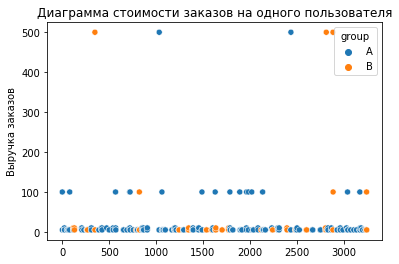

In [79]:
# Построим точечную диаграмму выручки заказов по группам:
x_values = pd.Series(range(0,len(orders['details'])))
sns.scatterplot(x=x_values, y=orders['details'], hue=orders['group'])
plt.title('Диаграмма стоимости заказов на одного пользователя') 
plt.ylabel('Выручка заказов')

In [80]:
# Посчитаем выборочные перцентили стоимости заказов
np.percentile(orders['details'], [95, 99])

array([ 99.99, 499.99])

Не более 5% заказов дороже 100 у.е и не более 1% дороже 500 у.е. Уникальных значений по стоимости не так много, очень похоже на подписку с разной ценой для разных периодов. Скорее всего выбросов тут нет.

### Вывод:

* Выручка у группы В равномерно увеличивается в течение всего теста. Хороший знак. У группы А график выручки растет более интенсивно, но это лишь подтверждает наши исследования выше, что в группе А больше количество пользователей, чем в группе В.
* Средний чек к концу теста начал немного стабилизироваться у обоих групп и примерно сравниваться. Возможно, в группу B 11-12 декабря попали крупные заказы (резкий всплеск на графике).
* В нескольких точках на графике относительного прироста среднего чека гр.В к гр.А резко «скачет». Где-то скорее всего спрятались крупные заказы и выбросы. Группа В значительно хуже группы А, но возможно, если бы распределение пользователей между группами было равномерным, то результат был бы другой.
* По графику коммулятивной конверсии по группам видно, что график не симметричный. Конверсия группы А вырвалась выше, обе конверсии выровнялись к концу теста и зафиксировались.
* В относительном приросте конверсии В к А в начале теста были колебания, с середины теста и до конца относительный прирост гр.В падает и врят ли уже начнет расти.
* Не более 5% заказов дороже 100 у.е и не более 1% дороже 500 у.е. 
* Диаграмма заказов на одного пользователя относительно равномерная, поэтому мы оставим все как есть.


## Проверка статистической разницы долей z-критерием.

Гипотезы для проверки наличия стат. значимых различий в конверсиях групп А и В теста:

* Нулевая гипотеза - между долями нет стат. значимой разницы.
* Альтернативная гипотеза - между долями есть стат. значимая разница.


In [81]:
df = ab_event.pivot_table(values='user_id',columns='group',index='event_name', aggfunc='nunique')
df

group,A,B
event_name,,
alogin,2747,928
browse_page,1780,523
product_cart,824,255
purchase,872,256


In [82]:
alpha = .05

for i, event in enumerate(df.iterrows()):
    if i == 0:
        pass
    else:
        print("Проверка стат. значимых различий в конверсиях групп на этапе: {}/{}".format(
            df.index[0],
            df.index[i])
             )
        
        part1 = df.iloc[i]['A']
        part2 = df.iloc[i]['B']
        total1 = df.iloc[0]['A']
        total2 = df.iloc[0]['B']

        # пропорция группы А
        p1 = part1 / total1
        # пропорция группы В
        p2 = part2 / total2
        # разница пропорций
        difference = p1 - p2

        # пропорция в комбинированном датасете
        p_combined = (part1 + part2) / (total1 + total2) 
        
        # статистика в ст.отклонениях стандартного нормального распределения
        z_value = difference / np.sqrt(
            p_combined * abs(1 - p_combined) * (1/total1 + 1/total2)
        )
        
        # нормальное распределение
        distr = st.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('p-значение: {:0.2f}'.format(p_value))
        bonferroni_alpha = alpha / 3  # поправка Бонферони на множественное сравнени
        if (p_value < bonferroni_alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

        print()

Проверка стат. значимых различий в конверсиях групп на этапе: alogin/browse_page
p-значение: 0.00
Отвергаем нулевую гипотезу: между долями есть значимая разница

Проверка стат. значимых различий в конверсиях групп на этапе: alogin/product_cart
p-значение: 0.15
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка стат. значимых различий в конверсиях групп на этапе: alogin/purchase
p-значение: 0.02
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



# Общий вывод:

I. Перед анализом, мы подготовили данные, а именно:
  * в таблице marketing тип данных в столбцах start_dt и finish_dt заменили на datetime
  * в таблице new_users тип данных в столбце first_date заменили на datetime
  * в таблице events тип данных в столбце event_dt заменили на datetime


II. Исследовательский анализ данных:

1. Тест проведен не корректно.

   Причины, почему тест проведен не корректно:

* в данных выявленно одновременно два теста
* тест завершился раньше срока. У группы А - 29 декабря, у группы В - 30 декабря. По ТЗ он должен завершится 04.01.2021. Не полные данные могут повлиять на результаты теста.
* Из региона EU ~13.73% новых пользователей. Не соответствие тех. заданию.
* Во время теста происходит два маркетинговых события "Рождественская и новогодняя акция" и "Новогодняя подарочная лотерея СНГ"
* 1602 пользователя участвуют одновременно в двух тестах.
* Пользователи распределены неравномерно по тестовым группам, в интересующем нас тесте разница между группами около 5%, это может исказить результаты теста.


2. Были выявлены следующие особенности:

* Количество событий на пользователя распределены в выборках не одинаково
* Число событий в выборках распределено по дням не равномерно
* Посмотрев на конверсию в воронке в выборках на разных этапах видно, что ожидаемго эффекта не произошло: пользователи не показали улучшение каждой метрики не менее, чем на 10%.
* Больше всего пользователей теряются между регистрацией и просмотром карточек.
* Количество пользователей, совершивших покупку, больше, чем количествово пользователей, попавших в корзину - вероятно, это связано с тем, что часть пользователей совершили покупку, минуя корзину.

III. Оценка результатов А/В-тестирования:
1. Анализ А/В теста:
* Выручка у группы В равномерно увеличивается в течение всего теста. Хороший знак. У группы А график выручки растет более интенсивно, но это лишь подтверждает наши исследования выше, что в группе А больше количество пользователей, чем в группе В.
* Средний чек к концу теста начал немного стабилизироваться у обоих групп и примерно сравниваться. Возможно, в группу B 11-12 декабря попали крупные заказы (резкий всплеск на графике).
* В нескольких точках на графике относительного прироста среднего чека гр.В к гр.А резко «скачет». Где-то скорее всего спрятались крупные заказы и выбросы. Группа В значительно хуже группы А, но возможно, если бы распределение пользователей между группами было равномерным, то результат был бы другой.
* По графику коммулятивной конверсии по группам видно, что график не симметричный. Конверсия группы А вырвалась выше, обе конверсии выровнялись к концу теста и зафиксировались.
* В относительном приросте конверсии В к А в начале теста были колебания, с середины теста и до конца относительный прирост гр.В падает и врят ли уже начнет расти.
* Исходя из диаграммы распределения стоимости заказов выбрали за верхнюю границу 100 у.е и отсекли аномальных пользователей по ней.
* Диаграмма заказов на одного пользователя относительно равномерная, поэтому мы оставим все как есть.

2. Проверка статистической разницы долей z-критерием:

* на этапе: alogin/browse_page, p-значение: 0.00 - отвергаем нулевую гипотезу: между долями есть значимая разница
* на этапе: alogin/product_cart, p-значение: 0.13 - не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
* на этапе: alogin/purchase, p-значение: 0.02 - не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


VI. Рекомендации:

Так как говорить об успешности теста нельзя, в виду обнаружения ряда ошибок при его проведении. Если довериться его результатам, возможно в будующем получить неприятные экономические последствия. Рекомендую скорректировать настройки A/B теста и запустить его повторно.